In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#######################
# Q1 Dataset Overview #
#######################

train_df = pd.read_csv("/content/drive/MyDrive/comp4211/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/comp4211/test.csv")
# X_train_df = train_df.iloc[:,:-2]
# y_regression_train_df = train_df['regression target']
# y_classification_train_df = train_df['classification target']


#######################
# Size of the Dataset #
#######################

print(train_df.shape)
print(test_df.shape)
# print(train_df.info)
print(train_df.describe())

#################
# Feature Types #
#################

for i in range(33):
  print(train_df.columns[i], ': ', train_df.iloc[:,i].unique()[1:20])

(3539, 33)
(876, 33)
                C6          C14          C16          C17          C18  \
count  3539.000000  3539.000000  3539.000000  3391.000000  3539.000000   
mean     66.324696    23.204012     0.683526     6.242996     8.248375   
std       6.619953     7.427675     2.275012     2.475471     4.202098   
min      47.500000    17.000000     0.000000     0.000000     0.000000   
25%      62.500000    19.000000     0.000000     5.000000     6.000000   
50%      66.550000    20.000000     0.000000     6.000000     8.000000   
75%      70.000000    25.000000     0.000000     7.000000    10.000000   
max      95.000000    70.000000    20.000000    26.000000    45.000000   

               C19          C20          C21          C22          C23  \
count  3539.000000  3368.000000  3539.000000  3523.000000  3511.000000   
mean      4.693416    10.624829     0.131958     0.522566     6.182284   
std       3.064981     4.852394     0.678628     1.853137     2.192147   
min       0.0000

In [ ]:
#####################
# Q2 Missing Values #
#####################

##################
# Identification #
##################

N = train_df.shape[0]
print(train_df.isnull().sum()[train_df.isnull().sum() != 0] / N)

C0     0.008194
C4     0.013846
C5     0.030517
C8     0.023170
C9     0.040124
C11    0.044645
C12    0.048036
C13    0.033908
C15    0.038994
C17    0.041820
C20    0.048319
C22    0.004521
C23    0.007912
C25    0.040689
C29    0.045211
dtype: float64


In [ ]:
###########################
# Q3 Feature Distribution #
###########################

M = train_df.shape[1]
for i in range(M):
  print(train_df.columns[i], '\t', train_df.iloc[:,i].unique()[:20])

######################
# Numerical Features #
######################

# Discrete: C14, C16, C17, C18, C19, C21, C22, C23, C24, C25, C27 (count = 11)
# Continuous: C6, C20, C26, C28, C29, C30, regression target (count = 7)

# C6, C14, C16

idx = [6,14,16]
plot_i = 1
for i in idx:
  col = train_df.iloc[:,i]
  print('mean: ', col.mean())
  print('median: ', col.median())
  print('range:', col.min(), ' to ', col.max())
  print('variance: ', np.var(col))
  plt.subplot(3, 1, plot_i)
  plot_i += 1
  plt.boxplot(col, vert=False)
  plt.ylabel('C' + str(i))


plt.suptitle('Distribution of first 3 numerical features')
plt.show()


########################
# Categorical Features #
########################

# Binary: C4, C8, C9, C10, C11, C12, C13, C15, classification target (count = 9)
# nominal = ['C0', 'C3', 'C4', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C15']
# ordinal = ['C1', 'C2', 'C5']
# Ordinal (hierarchy is implied):  C1, C5 (count = 2)
# Nominal (no hierarchy is implied): C0, C2, C3, C4, C7, C8, C9, C10, C11, C12, C13, C15, classification target (count = 13)

import numpy as np
idx = [0,1,2]

plot_i = 1
plt.figure(figsize=(18, 5))
for i in idx:
  plt.subplot(1, 3, plot_i)
  plot_i += 1
  plt.xlabel('C' + str(i))
  train_df.iloc[:,i].value_counts().plot(kind='bar')
  print(train_df.iloc[:,i].value_counts())
plt.suptitle('Distribution of first 3 categorical features')
plt.show()

C0 	 ['divorced' 'single' 'married' nan 'facto union' 'legally separated'
 'widower']
C1 	 ['Holders of other higher courses' 'Over 23 years old'
 '1st phase - general contingent'
 'Technological specialization diploma holders'
 '2nd phase - general contingent' 'Change of course'
 '3rd phase - general contingent' 'Short cycle diploma holders'
 '1st phase - special contingent (Madeira Island)' 'Transfer'
 'International student (bachelor)' 'Change of institution/course'
 '1st phase - special contingent (Azores Island)' 'Ordinance No. 854-B/99'
 'Ordinance No. 533-A/99, item b3 (Other Institution)'
 'Ordinance No. 533-A/99, item b2) (Different Plan)'
 'Ordinance No. 612/93' 'Change of institution/course (International)']
C2 	 ['second choice' 'seventh choice' 'fourth choice' 'third choice'
 'fifth choice' 'sixth choice' 'last choice' 'first choice']
C3 	 ['Management' 'Veterinary Nursing' 'Communication Design' 'Social Service'
 'Nursing' 'Informatics Engineering' 'Social Service (evenin

single               3115
married               296
divorced               75
facto union            18
legally separated       3
widower                 3
Name: C0, dtype: int64
1st phase - general contingent                         1351
2nd phase - general contingent                          708
Over 23 years old                                       630
Change of course                                        253
Technological specialization diploma holders            160
Holders of other higher courses                         109
3rd phase - general contingent                          105
Transfer                                                 67
Change of institution/course                             45
Short cycle diploma holders                              30
1st phase - special contingent (Madeira Island)          29
International student (bachelor)                         26
1st phase - special contingent (Azores Island)           14
Ordinance No. 854-B/99                   

Standard Deviation
C6< lower bound
18      50.0
20      50.0
114     50.0
307     50.0
387     50.0
        ... 
3236    50.0
3317    50.0
3370    50.0
3431    50.0
3536    50.0
Name: C6, Length: 77, dtype: float64
77
C6> upper bound
59      88.5
77      84.0
93      84.0
101     85.0
171     86.0
        ... 
3332    82.5
3373    95.0
3427    82.0
3487    90.0
3490    88.5
Name: C6, Length: 70, dtype: float64
70
C14< lower bound
Series([], Name: C14, dtype: int64)
0
C14> upper bound
0       35
3       42
40      35
47      38
49      42
        ..
3463    41
3484    38
3499    37
3518    36
3523    37
Name: C14, Length: 340, dtype: int64
340
C16< lower bound
Series([], Name: C16, dtype: int64)
0
C16> upper bound
5        2
12       2
14       1
17       3
18      11
        ..
3499     5
3500    11
3512     7
3528     8
3534     1
Name: C16, Length: 454, dtype: int64
454
Isolation Forest
        C6
18    50.0
20    50.0
41    80.5
52    55.5
59    88.5
...    ...
3450  53.5
3469  80.5

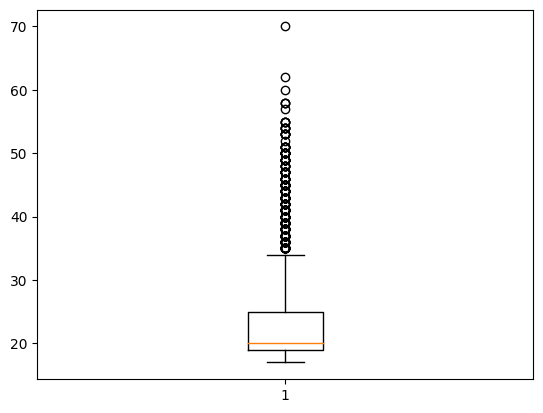

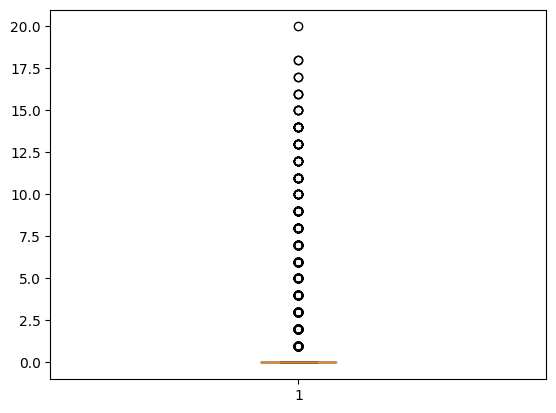

In [ ]:
##############
# Q4 outlier #
##############

#############
# Detection #
#############
"""
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 200)
y =

fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()
"""

idx = [6,14,16]

print('Standard Deviation')

for i in idx:
  col = train_df.iloc[:,i]
  plt.figure()
  plt.boxplot(col)
  q1 = col.quantile(0.25)
  q3 = col.quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  print('C' + str(i) + '< lower bound')
  print(col[col < lower_bound])
  print(col[col < lower_bound].size)
  print('C' + str(i) + '> upper bound')
  print(col[col > upper_bound])
  print(col[col > upper_bound].size)

print('Isolation Forest')

for i in idx:
  col = train_df.iloc[:,i:i+1]
  iso_forest = IsolationForest(contamination=0.1)
  iso_forest.fit(col)
  outliers = iso_forest.predict(col)
  print(col[outliers==-1])

<Axes: >

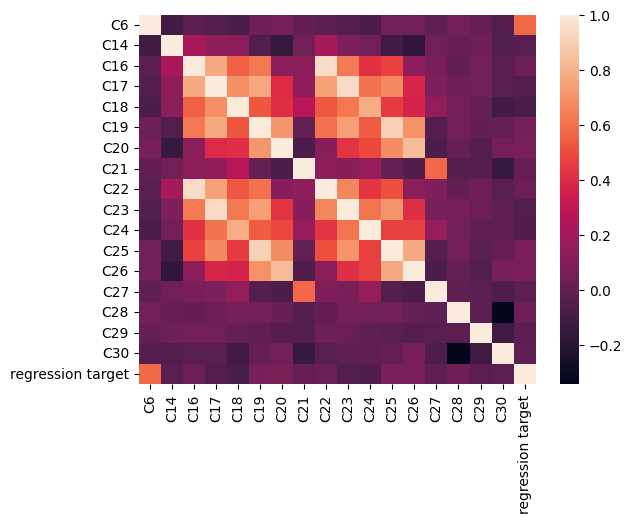

In [ ]:
###########################
# Q5 Correlation Analysis #
###########################

########################
# Feature Correleation #
########################

sns.heatmap(train_df.corr())

############
# Insights #
############

In [ ]:
########################################
# Q6 Initial Thoughts on Preprocessing #
########################################



In [ ]:
##############################
# Q7 Handling Missing Values #
##############################

imp_constant = SimpleImputer(fill_value=0, strategy='constant')
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

numerical = ['C6', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30']
categorical = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C15']

# print(len(categorical))
# print(len(numerical))
print(train_df.describe())
train_df_mean = train_df.copy()
train_df_median = train_df.copy()
train_df_mode = train_df.copy()
train_df_constant = train_df.copy()

for num in numerical:
  train_df_mean[[num]] = imp_mean.fit_transform(train_df[[num]])
  train_df_median[[num]] = imp_median.fit_transform(train_df[[num]])
  train_df_mode[[num]] = imp_mode.fit_transform(train_df[[num]])
  train_df_constant[[num]] = imp_constant.fit_transform(train_df[[num]])
  train_df[[num]] = imp_mean.fit_transform(train_df[[num]])

for cat in categorical:
  train_df[[cat]] = imp_most_frequent.fit_transform(train_df[[cat]])

# print(train_df.isnull().sum()[train_df.isnull().sum() != 0] / N)
print(train_df_mean.describe())
print(train_df_median.describe())
print(train_df_mode.describe())
print(train_df_constant.describe())

                C6          C14          C16          C17          C18  \
count  3539.000000  3539.000000  3539.000000  3391.000000  3539.000000   
mean     66.324696    23.204012     0.683526     6.242996     8.248375   
std       6.619953     7.427675     2.275012     2.475471     4.202098   
min      47.500000    17.000000     0.000000     0.000000     0.000000   
25%      62.500000    19.000000     0.000000     5.000000     6.000000   
50%      66.550000    20.000000     0.000000     6.000000     8.000000   
75%      70.000000    25.000000     0.000000     7.000000    10.000000   
max      95.000000    70.000000    20.000000    26.000000    45.000000   

               C19          C20          C21          C22          C23  \
count  3539.000000  3368.000000  3539.000000  3523.000000  3511.000000   
mean      4.693416    10.624829     0.131958     0.522566     6.182284   
std       3.064981     4.852394     0.678628     1.853137     2.192147   
min       0.000000     0.000000     0

In [ ]:
########################################
# Q8 Normalization and Standardization #
########################################
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

numerical_first = numerical[0]
print('Before processing: ')
print(train_df[numerical_first][:10])

train_df_robust = train_df.copy()
train_df_minmax = train_df.copy()


for num in numerical:
  train_df_robust[[num]] = robust_scaler.fit_transform(train_df[[num]])

for num in numerical:
  train_df_minmax[[num]] = minmax_scaler.fit_transform(train_df[[num]])

for num in numerical:
  train_df[[num]] = std_scaler.fit_transform(train_df[[num]])

print('After processing: ')
print(train_df[numerical_first][:10])

print(train_df.describe())
print(train_df_robust.describe())
print(train_df_minmax.describe())

Before processing: 
0    65.00
1    65.00
2    59.50
3    66.55
4    71.00
5    70.00
6    57.50
7    65.50
8    70.00
9    80.00
Name: C6, dtype: float64
After processing: 
0   -0.200135
1   -0.200135
2   -1.031074
3    0.034039
4    0.706344
5    0.555264
6   -1.333234
7   -0.124595
8    0.555264
9    2.066063
Name: C6, dtype: float64
                 C6           C14           C16           C17           C18  \
count  3.539000e+03  3.539000e+03  3.539000e+03  3.539000e+03  3.539000e+03   
mean   1.631297e-15  6.224025e-17  1.330134e-17  3.613950e-17 -7.629450e-17   
std    1.000141e+00  1.000141e+00  1.000141e+00  1.000141e+00  1.000141e+00   
min   -2.844032e+00 -8.353744e-01 -3.004921e-01 -2.576770e+00 -1.963196e+00   
25%   -5.778344e-01 -5.660731e-01 -3.004921e-01 -5.130414e-01 -5.351358e-01   
50%    3.403885e-02 -4.314224e-01 -3.004921e-01 -1.002956e-01 -5.911579e-02   
75%    5.552642e-01  2.418309e-01 -3.004921e-01  3.124501e-01  4.169042e-01   
max    4.332260e+00  6.301111

In [ ]:
#####################################
# Q9 Encoding Categorical Variables #
#####################################

onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')

# Ordinal (hierarchy is implied):  C1, C5 (count = 2)
# Nominal (no hierarchy is implied): C0, C2, C3, C4, C7, C8, C9, C10, C11, C12, C13, C15, classification target (count = 13)

nominal = ['C0', 'C1', 'C3', 'C4', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C15']
ordinal = ['C2', 'C5']
nominal_first = nominal[0]
ordinal_first = ordinal[0]

print('Before processing: ')
print(train_df[nominal_first][:10])

for nom in nominal:
  onehot_encoded_train = onehot_encoder.fit_transform(train_df[[nom]])
  onehot_encoded_train_df = pd.DataFrame(onehot_encoded_train, columns=onehot_encoder.get_feature_names_out([nom]))
  if nom == nominal_first:
    afterprocessing_nominal = onehot_encoded_train_df
  train_df = pd.concat([train_df, onehot_encoded_train_df], axis=1)
  train_df.drop(nom, inplace=True, axis=1)

print(afterprocessing_nominal)
#print(train_df.shape)
#print(train_df)
#for i in categorical:
#  train_df.iloc[:,i:i+1] = one_hot_encoder.fit_transform(train_df.iloc[:,i:i+1])

Before processing: 
0    divorced
1      single
2      single
3     married
4      single
5      single
6      single
7      single
8      single
9      single
Name: C0, dtype: object
      C0_facto union  C0_legally separated  C0_married  C0_single  C0_widower
0                0.0                   0.0         0.0        0.0         0.0
1                0.0                   0.0         0.0        1.0         0.0
2                0.0                   0.0         0.0        1.0         0.0
3                0.0                   0.0         1.0        0.0         0.0
4                0.0                   0.0         0.0        1.0         0.0
...              ...                   ...         ...        ...         ...
3534             0.0                   0.0         0.0        1.0         0.0
3535             0.0                   0.0         0.0        1.0         0.0
3536             0.0                   0.0         0.0        1.0         0.0
3537             0.0                

In [ ]:
#############################################
# Q9 Encoding Categorical Variables (cont.) #
#############################################

ordinal_encoder = OrdinalEncoder()

for ord in ordinal:
  ordinal_encoded = ordinal_encoder.fit_transform(train_df[[ord]])
  train_df[ord + '_ordinal'] = ordinal_encoded
  if ord == ordinal_first:
    afterprocessing_ordinal = ordinal_encoded
  train_df.drop(ord, inplace=True, axis=1)

In [ ]:
#############################################
# Q9 Encoding Categorical Variables (cont.) #
#############################################

print('After processing:')
print(afterprocessing_nominal)
print(afterprocessing_ordinal)

After processing:
      C0_facto union  C0_legally separated  C0_married  C0_single  C0_widower
0                0.0                   0.0         0.0        0.0         0.0
1                0.0                   0.0         0.0        1.0         0.0
2                0.0                   0.0         0.0        1.0         0.0
3                0.0                   0.0         1.0        0.0         0.0
4                0.0                   0.0         0.0        1.0         0.0
...              ...                   ...         ...        ...         ...
3534             0.0                   0.0         0.0        1.0         0.0
3535             0.0                   0.0         0.0        1.0         0.0
3536             0.0                   0.0         0.0        1.0         0.0
3537             0.0                   0.0         0.0        1.0         0.0
3538             0.0                   0.0         0.0        1.0         0.0

[3539 rows x 5 columns]
[[4.]
 [4.]
 [5.]
 ..

In [ ]:
##################################
# Division of dataset to X and y #
##################################
y_train_classification = train_df['classification target']
y_train_regression = train_df['regression target']
X_train_df = train_df.drop('classification target', axis=1)
X_train_df = X_train_df.drop('regression target', axis=1)


# train_df.drop('classification target_success', axis=1, inplace=True)
# train_df.drop('regression target', axis=1, inplace=True)


In [ ]:
#########################
# Q10 Feature Selection #
#########################

# Variance Threshold

# Regression
def ApplyVarianceThreshold(X_train_df, _threshold):
  sel = VarianceThreshold(threshold=(_threshold))
  sel.fit(X_train_df)
  print(X_train_df.columns[np.invert(sel.get_support())])
  return X_train_df.loc[:, sel.get_support()]


#ApplyVarianceThreshold(X_train_df, 0.001)

# Classification (pending)

In [ ]:
# Univariate Feature Selection

# Regression

def ApplyUnivariateFeatureSelection(X_train_df, _k, y_train):
  sel = SelectKBest(f_classif, k=_k)
  sel.fit(X_train_df, y_train)
  print(X_train_df.columns[sel.get_support()])
  return X_train_df.loc[:,sel.get_support()]


In [ ]:
###########################
# Q11 Feature Engineering #
###########################

# Engineer on features with high correlation, add x^2, x^3 sth like that (C6)

In [ ]:
#############
# Q12 - Q14 #
#############

best_features = ['C6', 'C1_Ordinance No. 854-B/99', 'C7_Cape Verdean', 'C7_Cuban',
       'C7_Mexican', 'C7_Ukrainian'] # use C2_ordinal for Q14
for feature in best_features:
  X_train, X_test, y_train, y_test = train_test_split(X_train_df[[feature]], y_train_regression,
                                                    test_size=0.2, random_state=4211)
  reg = LinearRegression().fit(X_train, y_train)
  y_predict = reg.predict(X_test)
  print(feature, reg.score(X_test, y_test))
  print(mean_squared_error(y_predict, y_test))
  # make prediction
  print(reg.predict(X_test))
  # print(1 - mean_squared_error(y_predict, y_test) / np.var(y_test)) alternative way to find R^2

# Last model

X_train, X_test, y_train, y_test = train_test_split(X_train_df[best_features], y_train_regression,
                                                    test_size=0.2, random_state=4211)

start = time.time()
reg = LinearRegression().fit(X_train, y_train)
end = time.time()
print(end - start)
print(reg.score(X_test, y_test))
print(mean_squared_error(y_predict, y_test))

# make prediction
print(reg.predict(X_test))




C6 0.3457983455467899
0.0031823076103367383
[0.66090184 0.69270118 0.56232388 0.6291025  0.61320283 0.61956269
 0.66408177 0.64500217 0.63578036 0.67998144 0.61320283 0.6291025
 0.63578036 0.75311993 0.57822355 0.66090184 0.6577219  0.60366302
 0.63228243 0.53052453 0.63578036 0.64500217 0.64182223 0.6577219
 0.67362158 0.68316138 0.63578036 0.59412322 0.59412322 0.61956269
 0.66408177 0.71814066 0.6291025  0.61320283 0.66726171 0.63578036
 0.64182223 0.6386423  0.6481821  0.59412322 0.72132059 0.75311993
 0.61956269 0.78491928 0.67680151 0.61638276 0.65136204 0.6386423
 0.6291025  0.66408177 0.61002289 0.68952125 0.6291025  0.65136204
 0.59412322 0.64182223 0.63578036 0.62592256 0.60366302 0.68952125
 0.60366302 0.63578036 0.65136204 0.67362158 0.55596401 0.75311993
 0.6577219  0.60366302 0.62592256 0.53052453 0.64500217 0.6577219
 0.59412322 0.58776335 0.59730315 0.64182223 0.60684296 0.60366302
 0.6291025  0.63578036 0.6291025  0.57822355 0.59412322 0.66408177
 0.58585539 0.64500217

In [ ]:
#############
# Q15 & Q16 #
#############

X_train, X_test, y_train, y_test = train_test_split(X_train_df[best_features], y_train_regression,
                                                    test_size=0.2, random_state=4211)
# print(best_features)
H = [1,8,32,128]
plot_y = []

for h in H:
  errors = []
  times = []
  error = 0
  for iter in range(3):
    start = time.time()
    reg = MLPRegressor(hidden_layer_sizes=[h, h, h], early_stopping=True, random_state=4211).fit(X_train, y_train)
    end = time.time()
    errors.append(reg.score(X_test, y_test))
    times.append(end - start)
  np_times = np.array(times)
  np_errors = np.array(errors)
  print('time mean: ', np.array(np_times).mean(), 'std: ', np.array(np_times).std())
  print('R2 mean: ', np.array(np_errors).mean(), 'std: ', np.array(np_errors).std())
  plot_y.append(np.array(np_errors).mean())
  # make prediction
  print(reg.predict(X_test))

plt.plot(H, plot_y)
plt.xlabel('H')
plt.ylabel('R2 score')

time mean:  0.8837955792744955 std:  0.09371344778545555
R2 mean:  -0.0018359866769823707 std:  0.0
[0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918 0.63252918
 0.63252918 0.63252918 0.6325

Text(0, 0.5, 'R2 score')

In [ ]:
#######
# Q17 #
#######
X_train, X_test, y_train, y_test = train_test_split(ApplyVarianceThreshold(X_train_df, 0.01), y_train_classification,
                                                    test_size=0.2)
"""
start = time.time()
reg = LogisticRegression(penalty='').fit(X_train, y_train)
end = time.time()

print('R2 score:',reg.score(X_test, y_test))
print(end - start)
"""

for penalty in ['elasticnet', 'l2', 'l1']:
  accuracy = []
  times = []
  f1_scores = []
  for repeat in range(3):
    start = time.time()
    clf = SGDClassifier(loss="log_loss", learning_rate='optimal', penalty=penalty)
    clf.fit(X_train, y_train)
    end = time.time()
    y_pred = clf.predict(X_test)
    accuracy.append(clf.score(X_test, y_test))
    times.append(end - start)
    f1_scores.append(f1_score(y_pred, y_test, pos_label='success'))
  print('Mean accuracy: ', np.array(accuracy).mean(), 'std: ', np.array(accuracy).std())
  print('Time:', np.array(times).mean(), 'std: ', np.array(times).std())
  print('F1 score:', np.array(f1_scores).mean(), 'std: ', np.array(f1_scores).std())
    # print('F1 score:', f1_score(y_pred, y_test, pos_label='success'))
    # cnf_matrix = confusion_matrix(y_test, y_pred)
    # cnf_matrix
  # print(y_pred.shape, y_test.shape)

Index(['C0_facto union', 'C0_legally separated', 'C0_widower',
       'C1_1st phase - special contingent (Azores Island)',
       'C1_1st phase - special contingent (Madeira Island)',
       'C1_Change of institution/course (International)',
       'C1_International student (bachelor)',
       'C1_Ordinance No. 533-A/99, item b2) (Different Plan)',
       'C1_Ordinance No. 533-A/99, item b3 (Other Institution)',
       'C1_Ordinance No. 612/93', 'C1_Ordinance No. 854-B/99',
       'C1_Short cycle diploma holders', 'C3_Biofuel Production Technologies',
       'C7_Brazilian', 'C7_Cape Verdean', 'C7_Colombian', 'C7_Cuban',
       'C7_Dutch', 'C7_German', 'C7_Guinean', 'C7_Italian', 'C7_Lithuanian',
       'C7_Mexican', 'C7_Moldova (Republic of)', 'C7_Mozambican', 'C7_Russian',
       'C7_Santomean', 'C7_Spanish', 'C7_Turkish', 'C7_Ukrainian'],
      dtype='object')
Mean accuracy:  0.7994350282485875 std:  0.03185542339743365
Time: 0.10103313128153484 std:  0.02412986132621073
F1 score: 0.

In [ ]:
#######
# Q18 #
#######
eta = 0.1
clf = SGDClassifier(loss="log_loss", learning_rate='adaptive', eta0=eta, penalty="l1", random_state=4211)
clf.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label='success')
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
print('auc score:', auc_score)

auc score: 0.9385699527744983


In [ ]:
#######
# Q19 #
#######
penalty='l1'
for eta in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
  print('eta: ', eta)
  clf = SGDClassifier(loss="log_loss", learning_rate='constant', eta0=eta, penalty=penalty, random_state=4211)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print('accuracy', clf.score(X_test, y_test))
  print('f1_score', f1_score(y_pred, y_test, pos_label='success'))

eta:  0.01
accuracy 0.8587570621468926
f1_score 0.8936170212765957
eta:  0.05
accuracy 0.8163841807909604
f1_score 0.8536036036036034
eta:  0.1
accuracy 0.788135593220339
f1_score 0.8655913978494623
eta:  0.15
accuracy 0.8220338983050848
f1_score 0.8839779005524862
eta:  0.2
accuracy 0.672316384180791
f1_score 0.6971279373368146
eta:  0.25
accuracy 0.847457627118644
f1_score 0.8800000000000001
eta:  0.3
accuracy 0.6765536723163842
f1_score 0.7014341590612777


Index(['C0_facto union', 'C0_legally separated', 'C0_widower',
       'C1_1st phase - special contingent (Azores Island)',
       'C1_1st phase - special contingent (Madeira Island)',
       'C1_Change of institution/course (International)',
       'C1_International student (bachelor)',
       'C1_Ordinance No. 533-A/99, item b2) (Different Plan)',
       'C1_Ordinance No. 533-A/99, item b3 (Other Institution)',
       'C1_Ordinance No. 612/93', 'C1_Ordinance No. 854-B/99',
       'C1_Short cycle diploma holders', 'C3_Biofuel Production Technologies',
       'C7_Brazilian', 'C7_Cape Verdean', 'C7_Colombian', 'C7_Cuban',
       'C7_Dutch', 'C7_German', 'C7_Guinean', 'C7_Italian', 'C7_Lithuanian',
       'C7_Mexican', 'C7_Moldova (Republic of)', 'C7_Mozambican', 'C7_Russian',
       'C7_Santomean', 'C7_Spanish', 'C7_Turkish', 'C7_Ukrainian'],
      dtype='object')
time mean:  0.2597908178965251 std:  0.019067624139282417
accuracy mean:  0.3036723163841808 std:  0.0
f1 score mean:  0.0 st

Text(0.5, 1.0, 'Accuracy against number of neurons')

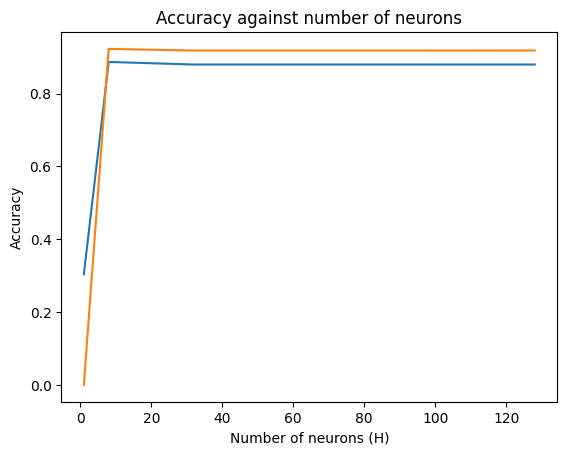

In [ ]:
##########
# Q20-24 #
##########

X_train, X_test, y_train, y_test = train_test_split(ApplyVarianceThreshold(X_train_df, 0.01), y_train_classification,
                                                    test_size=0.2, random_state=4211)

H = [1,8,32,128]
accuracy_plot = []
f1_score_plot = []
for h in H:
  errors = []
  times = []
  f1_scores=[]
  error = 0
  for iter in range(3):
    start = time.time()
    reg = MLPClassifier(hidden_layer_sizes=[h, h, h], early_stopping=True, random_state=4211).fit(X_train, y_train)
    end = time.time()
    y_pred = reg.predict(X_test)
    errors.append(reg.score(X_test, y_test))
    f1_scores.append(f1_score(y_pred, y_test, pos_label='success'))
    times.append(end - start)
  np_times = np.array(times)
  np_errors = np.array(errors)
  np_f1_scores = np.array(f1_scores)
  print('time mean: ', np.array(np_times).mean(), 'std: ', np.array(np_times).std())
  print('accuracy mean: ', np.array(np_errors).mean(), 'std: ', np.array(np_errors).std())
  print('f1 score mean: ', np.array(np_f1_scores).mean(), 'std: ', np.array(np_f1_scores).std())
  accuracy_plot.append(np.array(np_errors).mean())
  f1_score_plot.append(np.array(np_f1_scores).mean())

plt.plot(H, accuracy_plot, label='accuracy')
plt.plot(H, f1_score_plot, label='f1 score')
plt.xlabel('Number of neurons (H)')
plt.ylabel('Accuracy')
plt.title('Accuracy against number of neurons')


In [ ]:
#############
# Q24 - Q26 #
#############

train_df = pd.read_csv("/content/drive/MyDrive/comp4211/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/comp4211/test.csv")
y_train_classification = train_df['classification target']
y_train_regression = train_df['regression target']
X_train_df = train_df.drop('classification target', axis=1)
X_train_df = X_train_df.drop('regression target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_classification, test_size=0.2, random_state=4211)

numeric_features = ['C6', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30']
categorical_features = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C15']
nominal_features = nominal
ordinal_features = ordinal

numeric_transformerA = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

numeric_transformerB = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0)), ("scaler", MinMaxScaler())]
)

categorical_transformerA = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(drop='first', handle_unknown="ignore"))
    ]
)
nominal_transformerB = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("nominal", OneHotEncoder(drop='first', handle_unknown="ignore")),
    ]
)
ordinal_transformerB = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=100))
    ]
)

preprocessorA = ColumnTransformer(
    transformers=[
        ("num", numeric_transformerA, numeric_features),
        ("cat", categorical_transformerA, categorical_features),
    ]
)

preprocessorB = ColumnTransformer(
    transformers=[
        ("num", numeric_transformerB, numeric_features),
        ("ord", ordinal_transformerB, ordinal_features),
        ("nom", nominal_transformerB, nominal_features),
    ]
)

hidden_size = 32

clfA = Pipeline(
    steps=[("preprocessor", preprocessorA), ("classifier", MLPClassifier(hidden_layer_sizes=[hidden_size, hidden_size, hidden_size], early_stopping=True, random_state=4211))]
)

clfB = Pipeline(
    steps=[("preprocessor", preprocessorB), ("classifier", MLPClassifier(hidden_layer_sizes=[hidden_size, hidden_size, hidden_size], early_stopping=True, random_state=4211))]
)

clfC = Pipeline(
    steps=[("preprocessor", preprocessorA), ('feature_selection', SelectFromModel(LinearSVC(dual=False, penalty="l1", max_iter=10000))), ("classifier", MLPClassifier(hidden_layer_sizes=[hidden_size, hidden_size, hidden_size], early_stopping=True, random_state=4211))]
)

clfA.fit(X_train, y_train) # 0.884
clfB.fit(X_train, y_train) # 0.874
clfC.fit(X_train, y_train) # 0.901

print("A model accuracy: %.3f" % clfA.score(X_test, y_test))
y_pred = clfA.predict(X_test)
print("A model f1 score: ", f1_score(y_pred, y_test, pos_label='success'))
print("B model accuracy: %.3f" % clfB.score(X_test, y_test))
y_pred = clfB.predict(X_test)
print("B model f1 score: ", f1_score(y_pred, y_test, pos_label='success'))
print("C model accuracy: %.3f" % clfC.score(X_test, y_test))
y_pred = clfC.predict(X_test)
print("C model f1 score: ", f1_score(y_pred, y_test, pos_label='success'))


A model accuracy: 0.884
A model f1 score:  0.9189723320158103
B model accuracy: 0.874
B model f1 score:  0.9130009775171065
C model accuracy: 0.901
C model f1 score:  0.9321705426356589


In [ ]:
#######
# Q27 #
#######

pipe_parameters = [
    {
      'classifier__batch_size': [16, 32, 64, 128, 256],
      'classifier__learning_rate' : ['constant']
    }
]

grid_search = GridSearchCV(clfC, pipe_parameters, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:\n", grid_search.best_params_)
print(grid_search.score(X_test, y_test))

Best parameters found:
 {'classifier__batch_size': 32, 'classifier__learning_rate': 'constant'}
0.8940677966101694


In [ ]:
print(grid_search.cv_results_)

{'mean_fit_time': array([1.74021606, 1.10837574, 0.95146766, 0.67043452, 0.5654067 ]), 'std_fit_time': array([0.3001823 , 0.12867106, 0.29880865, 0.08468049, 0.10991427]), 'mean_score_time': array([0.01145673, 0.01356959, 0.01091685, 0.01046195, 0.01059742]), 'std_score_time': array([0.0018237 , 0.00284383, 0.00103265, 0.00049715, 0.00030039]), 'param_classifier__batch_size': masked_array(data=[16, 32, 64, 128, 256],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classifier__learning_rate': masked_array(data=['constant', 'constant', 'constant', 'constant',
                   'constant'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'classifier__batch_size': 16, 'classifier__learning_rate': 'constant'}, {'classifier__batch_size': 32, 'classifier__learning_rate': 'constant'}, {'classifier__batch_size': 64, 'classifier__learning_rate': 'constant'}, {'cla